# Trabalho Final

Importando as bibliotecas que serão usadas

In [1]:
# Util
import operator
import math
import random
import numpy as np
from numpy import linspace, sin, pi, int16
import matplotlib.pyplot as plt
%matplotlib inline

# Genetic Programming
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import librosa
import librosa.display
from IPython.display import Audio

import warnings; warnings.simplefilter('ignore')

Carregando o som desejado

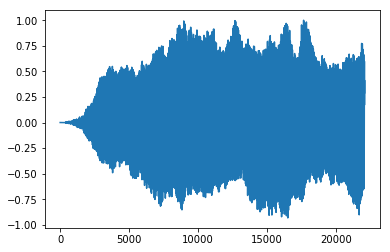

In [2]:
f0 = 440.0
#target, sr = librosa.load('SOUNDS/au_sample.wav')
#target, sr = librosa.load('SOUNDS/flute.wav')
#target, sr = librosa.load('SOUNDS/harp.wav')
target, sr = librosa.load('SOUNDS/string.wav')
target = librosa.util.normalize(target[:sr]) # normalizando etruncando para 1 segundo
duration = 1.0
plt.plot(target)
Audio(target,rate=sr)

In [3]:
# FUNCOES OPERADORES
def note(freq, amp=1.0):
    t = linspace(0,1.0,1.0*22050)
    data = sin(2.0*pi*freq*t)*amp
    return data

def fm(c_amp,c_freq, note_mod):
    t = linspace(0,1.0,1.0*22050)
    data = c_amp * sin(2.0*pi *(c_freq*t + note_mod))
    return data


In [4]:
def evaluate(individual):
    func = toolbox.compile(expr=individual)
    candidate = librosa.util.normalize(func(f0))
    
    candidate_mag = librosa.util.normalize(np.abs(librosa.stft(candidate)), axis=1)
    candidate_pha = librosa.util.normalize(np.angle(librosa.stft(candidate)), axis=1)
    
    target_mag = librosa.util.normalize(np.abs(librosa.stft(target)), axis=1)
    target_pha = librosa.util.normalize(np.angle(librosa.stft(target)), axis=1)
    
    mag_error = np.mean((candidate_mag - target_mag)**2)
    pha_error = np.mean((candidate_pha - target_pha)**2)
    
    return mag_error*0.7 + pha_error*0.3,

In [5]:
def evaluate_max(individual):
    func = toolbox.compile(expr=individual)
    candidate = librosa.util.normalize(func(f0))
    
    candidate_mag = np.abs(librosa.stft(candidate))
    candidate_pha = np.angle(librosa.stft(candidate))
    
    target_mag = np.abs(librosa.stft(target))
    target_pha = np.angle(librosa.stft(target))
    
    mag_error = np.max((candidate_mag - target_mag)**2)
    pha_error = np.max((candidate_pha - target_pha)**2)
    
    return (mag_error*0.7 + pha_error*0.3),

In [6]:
# PROGRAMAÇÂO GENETICA
pset = gp.PrimitiveSetTyped("MAIN", [float], np.ndarray, "F")

# OPERATORS
pset.addPrimitive(note, [float, float], np.ndarray)
pset.addPrimitive(operator.add,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(operator.mul,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(fm, [float,float,np.ndarray], np.ndarray)
pset.addPrimitive(operator.add,[float,float],float)
# pset.addPrimitive(gen_cos, [float,float], list)

# TERMINALS
# if not scoop.IS_ORIGIN:
#    pset.addEphemeralConstant("rand100", lambda: random.random() * 100, float)
pset.addEphemeralConstant("rand100", lambda: random.random() * 100, float)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1), float)
pset.addTerminal(note(0), np.ndarray, 'zero')
pset.addTerminal(note(f0), np.ndarray, 'fundamental')
pset.addTerminal(note(2*f0), np.ndarray, 'harm1')
pset.addTerminal(note(3*f0), np.ndarray, 'harm2')
pset.addTerminal(note(4*f0), np.ndarray, 'harm3')
pset.addTerminal(f0, float)
pset.addTerminal(2*f0, float)
pset.addTerminal(3*f0, float)
pset.addTerminal(4*f0, float)

# CONFIG
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# toolbox.register("map", futures.map)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evaluate_max)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

In [7]:
def main():
    random.seed(10)
    pop = toolbox.population(n=10000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, 0.75, 0.2, 50, stats, halloffame=hof)

    return pop, stats, hof

In [8]:
pop, stats, hof = main()

gen	nevals	avg   	std   	min    	max   
0  	10000 	112770	112023	13289.6	730740
1  	7970  	71118.6	63373.1	13289.6	724917
2  	7986  	55644.6	45868.4	13289.6	724917
3  	8005  	46038.6	36300.7	12699  	724917
4  	8071  	40968.1	31919.4	12699  	724917
5  	8084  	38809.5	34262.5	12421  	724917
6  	8004  	36045.5	30275.1	12517.9	724917
7  	7927  	35341  	34885.5	12228.8	724917
8  	8001  	34514.2	35695.9	12228.8	724917
9  	7974  	34005.1	33828.3	12228.8	724917
10 	7936  	33789.1	34276.1	12259.7	724917
11 	8020  	33791.2	36805.9	12244.4	724917
12 	8011  	33615.6	38534  	12296.9	729622
13 	7996  	33632.1	40355.7	12364.9	724917
14 	7968  	31253.2	32908.5	12264.3	724917
15 	8046  	31237.4	32218.2	12215.8	724917
16 	8053  	30057.2	29557.1	12151.4	724917
17 	8033  	29013.8	26915.9	12151.4	256426
18 	8046  	28451.5	27662.8	12146.3	724917
19 	7980  	27298.8	25118.5	12146.3	724917
20 	7982  	27499.5	26999.3	11863.2	724917
21 	7996  	26512  	28352.6	11309.4	724917
22 	8085  	26176.6	25378.1	11309.4	724

In [9]:
str(hof[0])

'add(fm(add(add(880.0, add(add(1320.0, add(F0, -1)), 1320.0)), 1320.0), 1760.0, harm2), add(add(mul(add(zero, harm2), zero), note(add(440.0, 10.035738944329397), add(10.035738944329397, F0))), fm(add(1760.0, 37.3002191608047), F0, fundamental)))'

In [10]:
func = toolbox.compile(hof[0])
candidate = librosa.util.normalize(func(f0))
Audio(candidate,rate=sr)

In [11]:
librosa.output.write_wav('SOUNDS/gen_string.wav',candidate,sr)

In [12]:
def print_signals(target,candidate):
    plt.figure(1,figsize=(15, 9))
    plt.subplot(221)
    plt.plot(target)
    
    plt.subplot(222)
    plt.plot(candidate)
    
    plt.subplot(223)
    D_target = librosa.amplitude_to_db(librosa.stft(target), ref=np.max)
    librosa.display.specshow(D_target, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('TARGET')
    
    plt.subplot(224)
    D_candidate = librosa.amplitude_to_db(librosa.stft(candidate), ref=np.max)
    librosa.display.specshow(D_candidate, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('CANDIDATE')

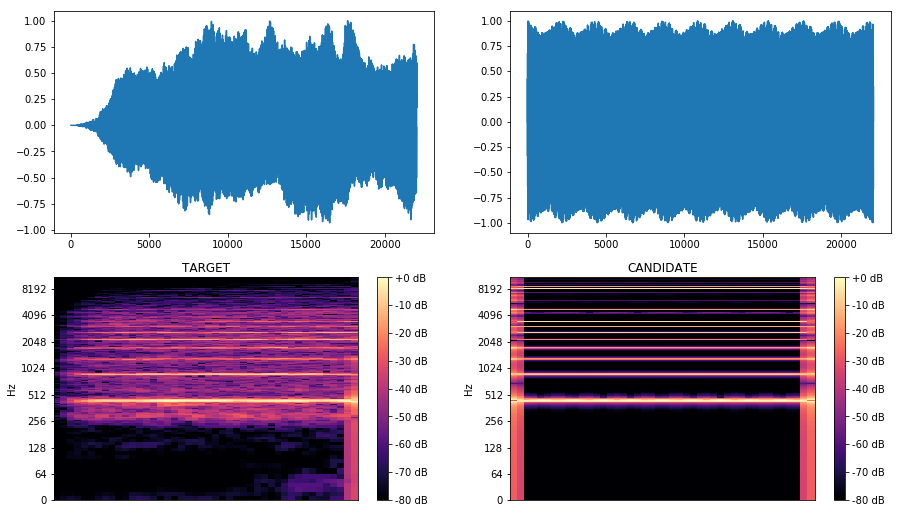

In [13]:
print_signals(target,candidate)